# 3. Train a Regression ConvNN Model using the BOHB Tuned Hyperparameters


In the following steps, you will: 

- Load the brown dwarf dataset used to train the ML models
- Prepare the X and y variables to deploy the trained ML models
- Visualize them for few cases

We will need the following modules from `TelescopeML`:

- *DeepBuilder*: to prepare the syntheric brown dwarf dataset, load the trained machine learning (ML) models
- *Predictor*: to prepare the observatinal brown dwarf dataset and deploy the trained ML models
- *StatVisAnalyzer*: provide statistical-test and plotting function  
- *IO_utils*: provide functions to load the trained ML models

In [1]:
from TelescopeML.DeepTrainer import *
from TelescopeML.DeepBuilder import *
from TelescopeML.Predictor import *
from TelescopeML.IO_utils import load_or_dump_trained_model_CNN
from TelescopeML.StatVisAnalyzer import regression_report

Loading BokehJS ...

/Users/egharibn/RESEARCH/ml/projects/TelescopeML_project/reference_data/


Loading BokehJS ...

Loading BokehJS ...

/Users/egharibn/RESEARCH/ml/projects/TelescopeML_project/reference_data/


## 3.1 Data Preperation 

### 3.1.1 Load the Synthetic spectra - training dataset

We computed a low-resolution spectrum ($R$=200) utilizing atmopshric brown dwarfs grid model, [*Sonora-Bobcat*](https://arxiv.org/pdf/2107.07434.pdf) for spectral range $\sim$0.9-2.4 $\mu m$. An open-source atmospheric radiative transfer Python package, [*PICASO*](https://natashabatalha.github.io/picaso/) was employed for generating these datasets. This dataset encompass 30,888 synthetic spectra (or instances or rows). 

Each spectrum has 104 features (or wavelengths in the astrophysics context, i.e., 0.897, 0.906, ..., 2.512~$\mu$m) and 4 parameters:
- gravity ( log$g$ ) 
- temperature ( T$_{eff}$ )
- carbon-to-oxygen ratio ( C/O )
- metallicity ( [M/H] )

In [2]:
# Read the `TelescopeML_reference_data` path

import os  # to check the path  

__reference_data_path__ = os.getenv("TelescopeML_reference_data")
__reference_data_path__

'/Users/egharibn/RESEARCH/ml/projects/TelescopeML_project/reference_data/'

 Load the dataset and check few instances 

In [3]:
train_BD = pd.read_csv(os.path.join(__reference_data_path__, 
                                    'training_datasets', 
                                    'browndwarf_R100_v4_newWL_v2.csv.bz2'), compression='bz2')
train_BD.head(5)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
3,5.0,1100,0.25,-0.3,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
4,5.0,1100,0.25,0.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


### 3.1.2 Check atmospheric parameters

- gravity ( log$g$ ) 
- temperature ( T$_{eff}$ )
- carbon-to-oxygen ratio ( C/O )
- metallicity ( [M/H] )

Note: one of the columns, *is_augmented*, is indicating whether this is a native dataset or an augmented one. let's just ignore it for now!

In [4]:
target_features = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[target_features].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [5]:
# training_features_labels: they are Wavelengths variables in string format

training_features_labels = [item for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_labels[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [6]:
# training_features_wl: they are Wavelengths variables 

training_features_wl = [float(item) for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_wl[:5]

[2.512, 2.487, 2.462, 2.438, 2.413]

In [7]:
wl_synthetic = pd.read_csv(os.path.join(__reference_data_path__, 
                                        'training_datasets', 
                                        'wl.csv'))
wl_synthetic.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


### 3.1.3 Prepare Inputs and outputs for ML models (X,y)
- X: 104 column variables or fluxes
- y: output variables: 'gravity', 'temperature',  'c_o_ratio', 'metallicity'

Note: one of the columns, *is_augmented*, is indicating whether this is a native dataset or an augmented one. let's just ignore it for now!


In [8]:
# to assure we are only training the module with the native non-augmented BD training dataset
train_BD = train_BD[train_BD['is_augmented'].isin(['no'])] 


# Training feature variables
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)


# Target/Output feature variables
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


log-transform the 'temperature' variable toreduce the skewness of the data, making it more symmetric and normal-like for the ML model


In [9]:
y.loc[:, 'temperature'] = np.log10(y['temperature'])

In [10]:
# check the output variables
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

## 3.2 Build the CNN model and Processing the Data

Here we instintiate BuildRegressorCNN class from DeepBuilder module to prepare the datasets and take the trained CNN (Convolutional Neural Networks) for us:

- Take the synthetic datasets
- Process them, e.g.
    - Divide them to three sets: train, validation, and test sets
    - Scale y variables
    - Scale X variables
    - Create new features 
    

### 3.2.1 Instintiate BuildRegressorCNN class from DeepBuilder module

In [11]:
build_cnn_regression = BuildRegressorCNN( 
                             feature_values=X.to_numpy(),
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN',
                                )

### 3.2.2 Split the dataset into train, validate and test sets

In [12]:
build_cnn_regression.split_train_validation_test(test_size=0.1, 
                                                 val_size=0.1, 
                                                 random_state_=100,)

### 3.2.3 Standardize X Variables Row-wise 

In [13]:
# Scale the X features using MinMax Scaler
build_cnn_regression.standardize_X_row_wise()

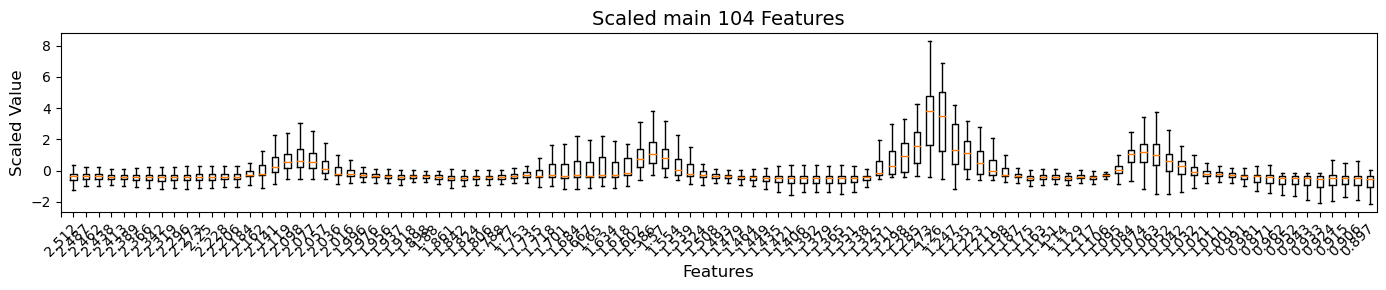

In [14]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.X_train_standardized_rowwise, 
                                                  xticks_list = training_features_labels,
                                                  title = 'Scaled main 104 Features',
                                                  fig_size=(14, 3),
                                                    )

### 3.2.4 Standardize y Variables Column-wise 

In [15]:
# Standardize the y features using Standard Scaler
build_cnn_regression.standardize_y_column_wise()

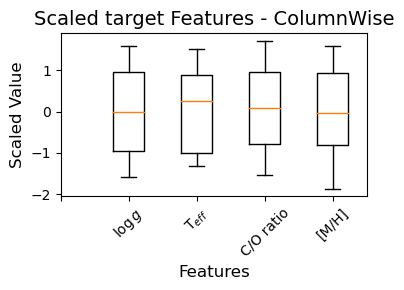

In [16]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.y_train_standardized_columnwise, 
                                                  xticks_list = ['','$\log g$', 'T$_{eff}$', 'C/O ratio', '[M/H]'],
                                                  title = 'Scaled target Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

### 3.2.5 Feature engeenering: Take Min and Max of each row (BD spectra) 

In [17]:
# train
build_cnn_regression.X_train_min = build_cnn_regression.X_train.min(axis=1)
build_cnn_regression.X_train_max = build_cnn_regression.X_train.max(axis=1)

# validation
build_cnn_regression.X_val_min = build_cnn_regression.X_val.min(axis=1)
build_cnn_regression.X_val_max = build_cnn_regression.X_val.max(axis=1)

# test
build_cnn_regression.X_test_min = build_cnn_regression.X_test.min(axis=1)
build_cnn_regression.X_test_max = build_cnn_regression.X_test.max(axis=1)

In [18]:
df_MinMax_train = pd.DataFrame((build_cnn_regression.X_train_min, build_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((build_cnn_regression.X_val_min, build_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((build_cnn_regression.X_test_min, build_cnn_regression.X_test_max)).T

In [19]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [20]:
df_MinMax_train.head()

,min,max
0,2.984493e-18,4.560593e-11
1,6.833671e-15,2.317328e-09
2,2.870361e-14,5.564836e-09
3,5.696652e-19,5.071436e-11
4,1.321553e-10,1.636513e-07


### 3.2.6 Scale Min Max features - ColumnWise

In [21]:
build_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.to_numpy(),
                                                X_val   = df_MinMax_val.to_numpy(),
                                                X_test  = df_MinMax_test.to_numpy(),
                                                )

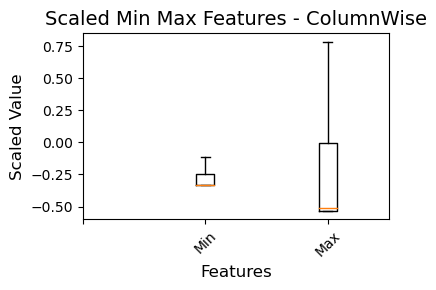

In [22]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.X_test_standardized_columnwise, 
                                                  xticks_list = ['','Min','Max'],
                                                  title = 'Scaled Min Max Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

## 3.3 Train CNN model

### 3.3.1 Instintiate *TrainRegressorCNN* class from *DeepTrainer* Module

In [23]:
train_cnn_model = TrainRegressorCNN(
            # input dataset: StandardScaled instances  
            X1_train = build_cnn_regression.X_train_standardized_rowwise,
            X1_val   = build_cnn_regression.X_val_standardized_rowwise,
            X1_test  = build_cnn_regression.X_test_standardized_rowwise,

            # input dataset: Min Max of each instance  
            X2_train = build_cnn_regression.X_train_standardized_columnwise,
            X2_val   = build_cnn_regression.X_val_standardized_columnwise,
            X2_test  = build_cnn_regression.X_test_standardized_columnwise,
#             X2_train = build_cnn_regression.X_train_normalized_columnwise,
#             X2_val   = build_cnn_regression.X_val_normalized_columnwise,
#             X2_test  = build_cnn_regression.X_test_normalized_columnwise,

            # 1st target
            y1_train = build_cnn_regression.y_train_standardized_columnwise[:,0],
            y1_val   = build_cnn_regression.y_val_standardized_columnwise[:,0],
            y1_test  = build_cnn_regression.y_test_standardized_columnwise[:,0],

            # 2nd target
            y2_train = build_cnn_regression.y_train_standardized_columnwise[:,1],
            y2_val   = build_cnn_regression.y_val_standardized_columnwise[:,1],
            y2_test  = build_cnn_regression.y_test_standardized_columnwise[:,1],

            # 3rd target
            y3_train = build_cnn_regression.y_train_standardized_columnwise[:,2],
            y3_val   = build_cnn_regression.y_val_standardized_columnwise[:,2],
            y3_test  = build_cnn_regression.y_test_standardized_columnwise[:,2],

            # 4th target
            y4_train = build_cnn_regression.y_train_standardized_columnwise[:,3],
            y4_val   = build_cnn_regression.y_val_standardized_columnwise[:,3],
            y4_test  = build_cnn_regression.y_test_standardized_columnwise[:,3],
            )

### 3.3.2 Define the Hyperparameters

In [24]:
hyperparameters = {'Conv__MaxPooling1D': 2,
                 'Conv__num_blocks': 1,
                 'Conv__num_layers_per_block': 3,
                 'Conv__num_filters': 4,
                 'Conv__kernel_size': 6,
                   
                 'FC2__num_blocks': 4,
                 'FC2_num_layers_per_block': 2,
                 'FC__dropout': 0.0024609140719442646,
                 'FC2__dropout': 64,
                 'FC2__units': 64,
#                  'FC__units_gravity': 16,
#                  'FC__units_metallicity': 256,
#                  'FC__units_temperature': 8,
                   
                 'FC1__num_blocks': 1,
                 'FC1_num_layers_per_block': 4,
                 'FC2__dropout': 0.09889223768186726,
                 'FC1__units': 128,
                 'FC1__dropout': 0.002185843015008406,
                   
                 'learning_rate': 4.9946842008422193e-05}

In [25]:
# hyperparameters = {
#      'Conv__MaxPooling1D': 2,
#      'Conv__num_blocks': 1,
#      'Conv__num_layers_per_block': 3,
#      'Conv__num_filters': 4,
#      'Conv__kernel_size': 6,
#      'FC__NumberLayers': 4,
    
#      'FC1__num_blocks' : 1,
#      'FC1_num_layers_per_block': 2,
#      'FC1__dropout': 0.09889223768186726,
#      'FC1__units': 128,

#      'FC2__num_blocks' : 1,
#      'FC2_num_layers_per_block':2,
#      'FC2__dropout': 0.0024609140719442646,
#      'FC2__units': 64,

    
#      'learning_rate': 4.9946842008422193e-05}

### 3.3.3 Build a CNN model

In [26]:
train_cnn_model.build_model(hyperparameters = hyperparameters, 
                     )

2023-11-08 22:22:38.786173: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 104, 1)]     0                                            
__________________________________________________________________________________________________
Conv__B1_L1 (Conv1D)            (None, 104, 16)      112         input_1[0][0]                    
__________________________________________________________________________________________________
Conv__B1_L2 (Conv1D)            (None, 104, 64)      6208        Conv__B1_L1[0][0]                
__________________________________________________________________________________________________
Conv__B1_L3 (Conv1D)            (None, 104, 144)     55440       Conv__B1_L2[0][0]                
______________________________________________________________________________________________

### 3.3.4 Train the CNN model using the datasets

In [27]:
history, model =  train_cnn_model.fit_cnn_model(batch_size=2**11,
                                                budget=4)

Epoch 1/4


2023-11-08 22:22:39.482422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 1/13 [=>............................] - ETA: 1:05 - loss: 1.8147 - gravity_loss: 0.4526 - c_o_ratio_loss: 0.4607 - metallicity_loss: 0.4572 - temperature_loss: 0.4442 - gravity_mae: 0.8508 - c_o_ratio_mae: 0.8811 - metallicity_mae: 0.8522 - temperature_mae: 0.8412

 2/13 [===>..........................] - ETA: 40s - loss: 1.8185 - gravity_loss: 0.4591 - c_o_ratio_loss: 0.4590 - metallicity_loss: 0.4538 - temperature_loss: 0.4466 - gravity_mae: 0.8586 - c_o_ratio_mae: 0.8772 - metallicity_mae: 0.8485 - temperature_mae: 0.8447 

 3/13 [=====>........................] - ETA: 35s - loss: 1.8017 - gravity_loss: 0.4563 - c_o_ratio_loss: 0.4607 - metallicity_loss: 0.4536 - temperature_loss: 0.4310 - gravity_mae: 0.8556 - c_o_ratio_mae: 0.8802 - metallicity_mae: 0.8478 - temperature_mae: 0.8263

 4/13 [========>.....................] - ETA: 31s - loss: 1.7657 - gravity_loss: 0.4545 - c_o_ratio_loss: 0.4641 - metallicity_loss: 0.4476 - temperature_loss: 0.3995 - gravity_mae: 0.8542 - c_o_ratio_mae: 0.8837 - metallicity_mae: 0.8404 - temperature_mae: 0.7866

 5/13 [==========>...................] - ETA: 28s - loss: 1.7065 - gravity_loss: 0.4538 - c_o_ratio_loss: 0.4641 - metallicity_loss: 0.4412 - temperature_loss: 0.3474 - gravity_mae: 0.8547 - c_o_ratio_mae: 0.8826 - metallicity_mae: 0.8329 - temperature_mae: 0.7141

 6/13 [============>.................] - ETA: 24s - loss: 1.6438 - gravity_loss: 0.4514 - c_o_ratio_loss: 0.4612 - metallicity_loss: 0.4279 - temperature_loss: 0.3034 - gravity_mae: 0.8522 - c_o_ratio_mae: 0.8789 - metallicity_mae: 0.8170 - temperature_mae: 0.6504

 7/13 [===============>..............] - ETA: 21s - loss: 1.5935 - gravity_loss: 0.4495 - c_o_ratio_loss: 0.4574 - metallicity_loss: 0.4109 - temperature_loss: 0.2757 - gravity_mae: 0.8498 - c_o_ratio_mae: 0.8735 - metallicity_mae: 0.7961 - temperature_mae: 0.6137

 8/13 [=================>............] - ETA: 18s - loss: 1.5431 - gravity_loss: 0.4464 - c_o_ratio_loss: 0.4535 - metallicity_loss: 0.3918 - temperature_loss: 0.2513 - gravity_mae: 0.8463 - c_o_ratio_mae: 0.8686 - metallicity_mae: 0.7721 - temperature_mae: 0.5792

 9/13 [===================>..........] - ETA: 14s - loss: 1.5294 - gravity_loss: 0.4408 - c_o_ratio_loss: 0.4500 - metallicity_loss: 0.3744 - temperature_loss: 0.2642 - gravity_mae: 0.8392 - c_o_ratio_mae: 0.8646 - metallicity_mae: 0.7490 - temperature_mae: 0.6037

10/13 [======================>.......] - ETA: 11s - loss: 1.4924 - gravity_loss: 0.4379 - c_o_ratio_loss: 0.4447 - metallicity_loss: 0.3644 - temperature_loss: 0.2454 - gravity_mae: 0.8360 - c_o_ratio_mae: 0.8584 - metallicity_mae: 0.7355 - temperature_mae: 0.5762

11/13 [========================>.....] - ETA: 7s - loss: 1.4739 - gravity_loss: 0.4348 - c_o_ratio_loss: 0.4416 - metallicity_loss: 0.3525 - temperature_loss: 0.2450 - gravity_mae: 0.8317 - c_o_ratio_mae: 0.8543 - metallicity_mae: 0.7198 - temperature_mae: 0.5770 

12/13 [==========================>...] - ETA: 3s - loss: 1.4487 - gravity_loss: 0.4311 - c_o_ratio_loss: 0.4371 - metallicity_loss: 0.3433 - temperature_loss: 0.2372 - gravity_mae: 0.8274 - c_o_ratio_mae: 0.8482 - metallicity_mae: 0.7074 - temperature_mae: 0.5669

13/13 [==============================] - ETA: 0s - loss: 1.4415 - gravity_loss: 0.4306 - c_o_ratio_loss: 0.4358 - metallicity_loss: 0.3406 - temperature_loss: 0.2344 - gravity_mae: 0.8269 - c_o_ratio_mae: 0.8465 - metallicity_mae: 0.7037 - temperature_mae: 0.5629

13/13 [==============================] - 51s 4s/step - loss: 1.4415 - gravity_loss: 0.4306 - c_o_ratio_loss: 0.4358 - metallicity_loss: 0.3406 - temperature_loss: 0.2344 - gravity_mae: 0.8269 - c_o_ratio_mae: 0.8465 - metallicity_mae: 0.7037 - temperature_mae: 0.5629 - val_loss: 1.0134 - val_gravity_loss: 0.3819 - val_c_o_ratio_loss: 0.3458 - val_metallicity_loss: 0.2055 - val_temperature_loss: 0.0802 - val_gravity_mae: 0.7665 - val_c_o_ratio_mae: 0.7288 - val_metallicity_mae: 0.5191 - val_temperature_mae: 0.3346


Epoch 2/4


 1/13 [=>............................] - ETA: 41s - loss: 1.0904 - gravity_loss: 0.4083 - c_o_ratio_loss: 0.3650 - metallicity_loss: 0.2147 - temperature_loss: 0.1024 - gravity_mae: 0.7979 - c_o_ratio_mae: 0.7551 - metallicity_mae: 0.5406 - temperature_mae: 0.3804

 2/13 [===>..........................] - ETA: 39s - loss: 1.0659 - gravity_loss: 0.3936 - c_o_ratio_loss: 0.3529 - metallicity_loss: 0.2141 - temperature_loss: 0.1053 - gravity_mae: 0.7793 - c_o_ratio_mae: 0.7396 - metallicity_mae: 0.5394 - temperature_mae: 0.3866

 3/13 [=====>........................] - ETA: 37s - loss: 1.0495 - gravity_loss: 0.3913 - c_o_ratio_loss: 0.3482 - metallicity_loss: 0.2178 - temperature_loss: 0.0922 - gravity_mae: 0.7771 - c_o_ratio_mae: 0.7314 - metallicity_mae: 0.5422 - temperature_mae: 0.3575

 4/13 [========>.....................] - ETA: 34s - loss: 1.0086 - gravity_loss: 0.3789 - c_o_ratio_loss: 0.3391 - metallicity_loss: 0.2138 - temperature_loss: 0.0768 - gravity_mae: 0.7616 - c_o_ratio_mae: 0.7183 - metallicity_mae: 0.5359 - temperature_mae: 0.3161

 5/13 [==========>...................] - ETA: 30s - loss: 0.9926 - gravity_loss: 0.3767 - c_o_ratio_loss: 0.3279 - metallicity_loss: 0.2120 - temperature_loss: 0.0760 - gravity_mae: 0.7583 - c_o_ratio_mae: 0.7012 - metallicity_mae: 0.5333 - temperature_mae: 0.3161

 6/13 [============>.................] - ETA: 26s - loss: 0.9770 - gravity_loss: 0.3754 - c_o_ratio_loss: 0.3178 - metallicity_loss: 0.2090 - temperature_loss: 0.0747 - gravity_mae: 0.7555 - c_o_ratio_mae: 0.6869 - metallicity_mae: 0.5290 - temperature_mae: 0.3137

 7/13 [===============>..............] - ETA: 22s - loss: 0.9542 - gravity_loss: 0.3713 - c_o_ratio_loss: 0.3111 - metallicity_loss: 0.2042 - temperature_loss: 0.0676 - gravity_mae: 0.7500 - c_o_ratio_mae: 0.6757 - metallicity_mae: 0.5221 - temperature_mae: 0.2940

 8/13 [=================>............] - ETA: 18s - loss: 0.9388 - gravity_loss: 0.3667 - c_o_ratio_loss: 0.3055 - metallicity_loss: 0.2023 - temperature_loss: 0.0643 - gravity_mae: 0.7440 - c_o_ratio_mae: 0.6669 - metallicity_mae: 0.5192 - temperature_mae: 0.2871

 9/13 [===================>..........] - ETA: 15s - loss: 0.9231 - gravity_loss: 0.3620 - c_o_ratio_loss: 0.2978 - metallicity_loss: 0.2010 - temperature_loss: 0.0623 - gravity_mae: 0.7374 - c_o_ratio_mae: 0.6564 - metallicity_mae: 0.5180 - temperature_mae: 0.2834

10/13 [======================>.......] - ETA: 11s - loss: 0.9108 - gravity_loss: 0.3602 - c_o_ratio_loss: 0.2913 - metallicity_loss: 0.2004 - temperature_loss: 0.0589 - gravity_mae: 0.7352 - c_o_ratio_mae: 0.6475 - metallicity_mae: 0.5174 - temperature_mae: 0.2737

11/13 [========================>.....] - ETA: 7s - loss: 0.8980 - gravity_loss: 0.3566 - c_o_ratio_loss: 0.2851 - metallicity_loss: 0.1998 - temperature_loss: 0.0565 - gravity_mae: 0.7307 - c_o_ratio_mae: 0.6373 - metallicity_mae: 0.5165 - temperature_mae: 0.2674 

12/13 [==========================>...] - ETA: 3s - loss: 0.8872 - gravity_loss: 0.3535 - c_o_ratio_loss: 0.2786 - metallicity_loss: 0.1994 - temperature_loss: 0.0556 - gravity_mae: 0.7266 - c_o_ratio_mae: 0.6281 - metallicity_mae: 0.5162 - temperature_mae: 0.2656

13/13 [==============================] - ETA: 0s - loss: 0.8851 - gravity_loss: 0.3529 - c_o_ratio_loss: 0.2774 - metallicity_loss: 0.1995 - temperature_loss: 0.0553 - gravity_mae: 0.7258 - c_o_ratio_mae: 0.6263 - metallicity_mae: 0.5164 - temperature_mae: 0.2649

13/13 [==============================] - 47s 4s/step - loss: 0.8851 - gravity_loss: 0.3529 - c_o_ratio_loss: 0.2774 - metallicity_loss: 0.1995 - temperature_loss: 0.0553 - gravity_mae: 0.7258 - c_o_ratio_mae: 0.6263 - metallicity_mae: 0.5164 - temperature_mae: 0.2649 - val_loss: 0.6754 - val_gravity_loss: 0.2987 - val_c_o_ratio_loss: 0.1754 - val_metallicity_loss: 0.1822 - val_temperature_loss: 0.0191 - val_gravity_mae: 0.6514 - val_c_o_ratio_mae: 0.4634 - val_metallicity_mae: 0.4926 - val_temperature_mae: 0.1533


Epoch 3/4


 1/13 [=>............................] - ETA: 45s - loss: 0.7229 - gravity_loss: 0.3123 - c_o_ratio_loss: 0.1867 - metallicity_loss: 0.1988 - temperature_loss: 0.0252 - gravity_mae: 0.6729 - c_o_ratio_mae: 0.4889 - metallicity_mae: 0.5178 - temperature_mae: 0.1762

 2/13 [===>..........................] - ETA: 40s - loss: 0.7261 - gravity_loss: 0.3214 - c_o_ratio_loss: 0.1860 - metallicity_loss: 0.1925 - temperature_loss: 0.0262 - gravity_mae: 0.6807 - c_o_ratio_mae: 0.4899 - metallicity_mae: 0.5078 - temperature_mae: 0.1818

 3/13 [=====>........................] - ETA: 36s - loss: 0.7186 - gravity_loss: 0.3182 - c_o_ratio_loss: 0.1841 - metallicity_loss: 0.1888 - temperature_loss: 0.0275 - gravity_mae: 0.6762 - c_o_ratio_mae: 0.4892 - metallicity_mae: 0.5011 - temperature_mae: 0.1878

 4/13 [========>.....................] - ETA: 32s - loss: 0.7053 - gravity_loss: 0.3150 - c_o_ratio_loss: 0.1784 - metallicity_loss: 0.1858 - temperature_loss: 0.0261 - gravity_mae: 0.6732 - c_o_ratio_mae: 0.4788 - metallicity_mae: 0.4954 - temperature_mae: 0.1823

 5/13 [==========>...................] - ETA: 29s - loss: 0.6978 - gravity_loss: 0.3131 - c_o_ratio_loss: 0.1743 - metallicity_loss: 0.1854 - temperature_loss: 0.0250 - gravity_mae: 0.6710 - c_o_ratio_mae: 0.4730 - metallicity_mae: 0.4938 - temperature_mae: 0.1784

 6/13 [============>.................] - ETA: 26s - loss: 0.6910 - gravity_loss: 0.3116 - c_o_ratio_loss: 0.1699 - metallicity_loss: 0.1846 - temperature_loss: 0.0248 - gravity_mae: 0.6690 - c_o_ratio_mae: 0.4644 - metallicity_mae: 0.4923 - temperature_mae: 0.1774

 7/13 [===============>..............] - ETA: 24s - loss: 0.6833 - gravity_loss: 0.3111 - c_o_ratio_loss: 0.1669 - metallicity_loss: 0.1813 - temperature_loss: 0.0240 - gravity_mae: 0.6681 - c_o_ratio_mae: 0.4592 - metallicity_mae: 0.4874 - temperature_mae: 0.1740

 8/13 [=================>............] - ETA: 20s - loss: 0.6759 - gravity_loss: 0.3094 - c_o_ratio_loss: 0.1637 - metallicity_loss: 0.1795 - temperature_loss: 0.0231 - gravity_mae: 0.6660 - c_o_ratio_mae: 0.4541 - metallicity_mae: 0.4857 - temperature_mae: 0.1703

 9/13 [===================>..........] - ETA: 17s - loss: 0.6718 - gravity_loss: 0.3100 - c_o_ratio_loss: 0.1604 - metallicity_loss: 0.1789 - temperature_loss: 0.0225 - gravity_mae: 0.6666 - c_o_ratio_mae: 0.4487 - metallicity_mae: 0.4851 - temperature_mae: 0.1674

10/13 [======================>.......] - ETA: 13s - loss: 0.6657 - gravity_loss: 0.3082 - c_o_ratio_loss: 0.1576 - metallicity_loss: 0.1779 - temperature_loss: 0.0220 - gravity_mae: 0.6640 - c_o_ratio_mae: 0.4443 - metallicity_mae: 0.4836 - temperature_mae: 0.1655

11/13 [========================>.....] - ETA: 8s - loss: 0.6609 - gravity_loss: 0.3073 - c_o_ratio_loss: 0.1554 - metallicity_loss: 0.1769 - temperature_loss: 0.0213 - gravity_mae: 0.6630 - c_o_ratio_mae: 0.4397 - metallicity_mae: 0.4819 - temperature_mae: 0.1627 

12/13 [==========================>...] - ETA: 4s - loss: 0.6566 - gravity_loss: 0.3063 - c_o_ratio_loss: 0.1537 - metallicity_loss: 0.1758 - temperature_loss: 0.0208 - gravity_mae: 0.6617 - c_o_ratio_mae: 0.4380 - metallicity_mae: 0.4803 - temperature_mae: 0.1607

13/13 [==============================] - ETA: 0s - loss: 0.6549 - gravity_loss: 0.3059 - c_o_ratio_loss: 0.1529 - metallicity_loss: 0.1754 - temperature_loss: 0.0207 - gravity_mae: 0.6611 - c_o_ratio_mae: 0.4367 - metallicity_mae: 0.4799 - temperature_mae: 0.1602

13/13 [==============================] - 58s 5s/step - loss: 0.6549 - gravity_loss: 0.3059 - c_o_ratio_loss: 0.1529 - metallicity_loss: 0.1754 - temperature_loss: 0.0207 - gravity_mae: 0.6611 - c_o_ratio_mae: 0.4367 - metallicity_mae: 0.4799 - temperature_mae: 0.1602 - val_loss: 0.5619 - val_gravity_loss: 0.2762 - val_c_o_ratio_loss: 0.1096 - val_metallicity_loss: 0.1643 - val_temperature_loss: 0.0117 - val_gravity_mae: 0.6197 - val_c_o_ratio_mae: 0.3595 - val_metallicity_mae: 0.4653 - val_temperature_mae: 0.1216


Epoch 4/4


 1/13 [=>............................] - ETA: 1:01 - loss: 0.5871 - gravity_loss: 0.2859 - c_o_ratio_loss: 0.1199 - metallicity_loss: 0.1680 - temperature_loss: 0.0133 - gravity_mae: 0.6370 - c_o_ratio_mae: 0.3799 - metallicity_mae: 0.4697 - temperature_mae: 0.1277

 2/13 [===>..........................] - ETA: 54s - loss: 0.5935 - gravity_loss: 0.2910 - c_o_ratio_loss: 0.1157 - metallicity_loss: 0.1730 - temperature_loss: 0.0137 - gravity_mae: 0.6402 - c_o_ratio_mae: 0.3779 - metallicity_mae: 0.4789 - temperature_mae: 0.1301 

 3/13 [=====>........................] - ETA: 49s - loss: 0.5912 - gravity_loss: 0.2915 - c_o_ratio_loss: 0.1168 - metallicity_loss: 0.1694 - temperature_loss: 0.0133 - gravity_mae: 0.6393 - c_o_ratio_mae: 0.3773 - metallicity_mae: 0.4723 - temperature_mae: 0.1285

 4/13 [========>.....................] - ETA: 43s - loss: 0.5807 - gravity_loss: 0.2883 - c_o_ratio_loss: 0.1134 - metallicity_loss: 0.1662 - temperature_loss: 0.0128 - gravity_mae: 0.6343 - c_o_ratio_mae: 0.3722 - metallicity_mae: 0.4683 - temperature_mae: 0.1261

 5/13 [==========>...................] - ETA: 39s - loss: 0.5736 - gravity_loss: 0.2848 - c_o_ratio_loss: 0.1117 - metallicity_loss: 0.1643 - temperature_loss: 0.0128 - gravity_mae: 0.6308 - c_o_ratio_mae: 0.3693 - metallicity_mae: 0.4657 - temperature_mae: 0.1259

 6/13 [============>.................] - ETA: 34s - loss: 0.5695 - gravity_loss: 0.2822 - c_o_ratio_loss: 0.1098 - metallicity_loss: 0.1647 - temperature_loss: 0.0127 - gravity_mae: 0.6274 - c_o_ratio_mae: 0.3642 - metallicity_mae: 0.4646 - temperature_mae: 0.1257

 7/13 [===============>..............] - ETA: 29s - loss: 0.5699 - gravity_loss: 0.2828 - c_o_ratio_loss: 0.1110 - metallicity_loss: 0.1635 - temperature_loss: 0.0126 - gravity_mae: 0.6276 - c_o_ratio_mae: 0.3672 - metallicity_mae: 0.4629 - temperature_mae: 0.1250

 8/13 [=================>............] - ETA: 24s - loss: 0.5620 - gravity_loss: 0.2796 - c_o_ratio_loss: 0.1086 - metallicity_loss: 0.1612 - temperature_loss: 0.0125 - gravity_mae: 0.6231 - c_o_ratio_mae: 0.3622 - metallicity_mae: 0.4594 - temperature_mae: 0.1246

 9/13 [===================>..........] - ETA: 19s - loss: 0.5568 - gravity_loss: 0.2777 - c_o_ratio_loss: 0.1069 - metallicity_loss: 0.1597 - temperature_loss: 0.0125 - gravity_mae: 0.6209 - c_o_ratio_mae: 0.3583 - metallicity_mae: 0.4573 - temperature_mae: 0.1241

10/13 [======================>.......] - ETA: 14s - loss: 0.5561 - gravity_loss: 0.2766 - c_o_ratio_loss: 0.1075 - metallicity_loss: 0.1596 - temperature_loss: 0.0124 - gravity_mae: 0.6196 - c_o_ratio_mae: 0.3602 - metallicity_mae: 0.4577 - temperature_mae: 0.1237

11/13 [========================>.....] - ETA: 9s - loss: 0.5553 - gravity_loss: 0.2769 - c_o_ratio_loss: 0.1073 - metallicity_loss: 0.1586 - temperature_loss: 0.0124 - gravity_mae: 0.6199 - c_o_ratio_mae: 0.3589 - metallicity_mae: 0.4562 - temperature_mae: 0.1236 

12/13 [==========================>...] - ETA: 4s - loss: 0.5522 - gravity_loss: 0.2760 - c_o_ratio_loss: 0.1061 - metallicity_loss: 0.1578 - temperature_loss: 0.0123 - gravity_mae: 0.6188 - c_o_ratio_mae: 0.3564 - metallicity_mae: 0.4550 - temperature_mae: 0.1231

13/13 [==============================] - ETA: 0s - loss: 0.5518 - gravity_loss: 0.2758 - c_o_ratio_loss: 0.1061 - metallicity_loss: 0.1576 - temperature_loss: 0.0123 - gravity_mae: 0.6187 - c_o_ratio_mae: 0.3564 - metallicity_mae: 0.4547 - temperature_mae: 0.1230

13/13 [==============================] - 62s 5s/step - loss: 0.5518 - gravity_loss: 0.2758 - c_o_ratio_loss: 0.1061 - metallicity_loss: 0.1576 - temperature_loss: 0.0123 - gravity_mae: 0.6187 - c_o_ratio_mae: 0.3564 - metallicity_mae: 0.4547 - temperature_mae: 0.1230 - val_loss: 0.4851 - val_gravity_loss: 0.2443 - val_c_o_ratio_loss: 0.0957 - val_metallicity_loss: 0.1363 - val_temperature_loss: 0.0088 - val_gravity_mae: 0.5648 - val_c_o_ratio_mae: 0.3326 - val_metallicity_mae: 0.4249 - val_temperature_mae: 0.1035


### 3.3.5 Check the Trained CNN Archeticture and Summary

Checking the architecture of a CNN and its summary is importnat because it provide insights about: 
- Model Design and Structure
- Model complexity
- Hyperparameter Tuning:

In [28]:
build_cnn_regression.trained_model = model
build_cnn_regression.history = history

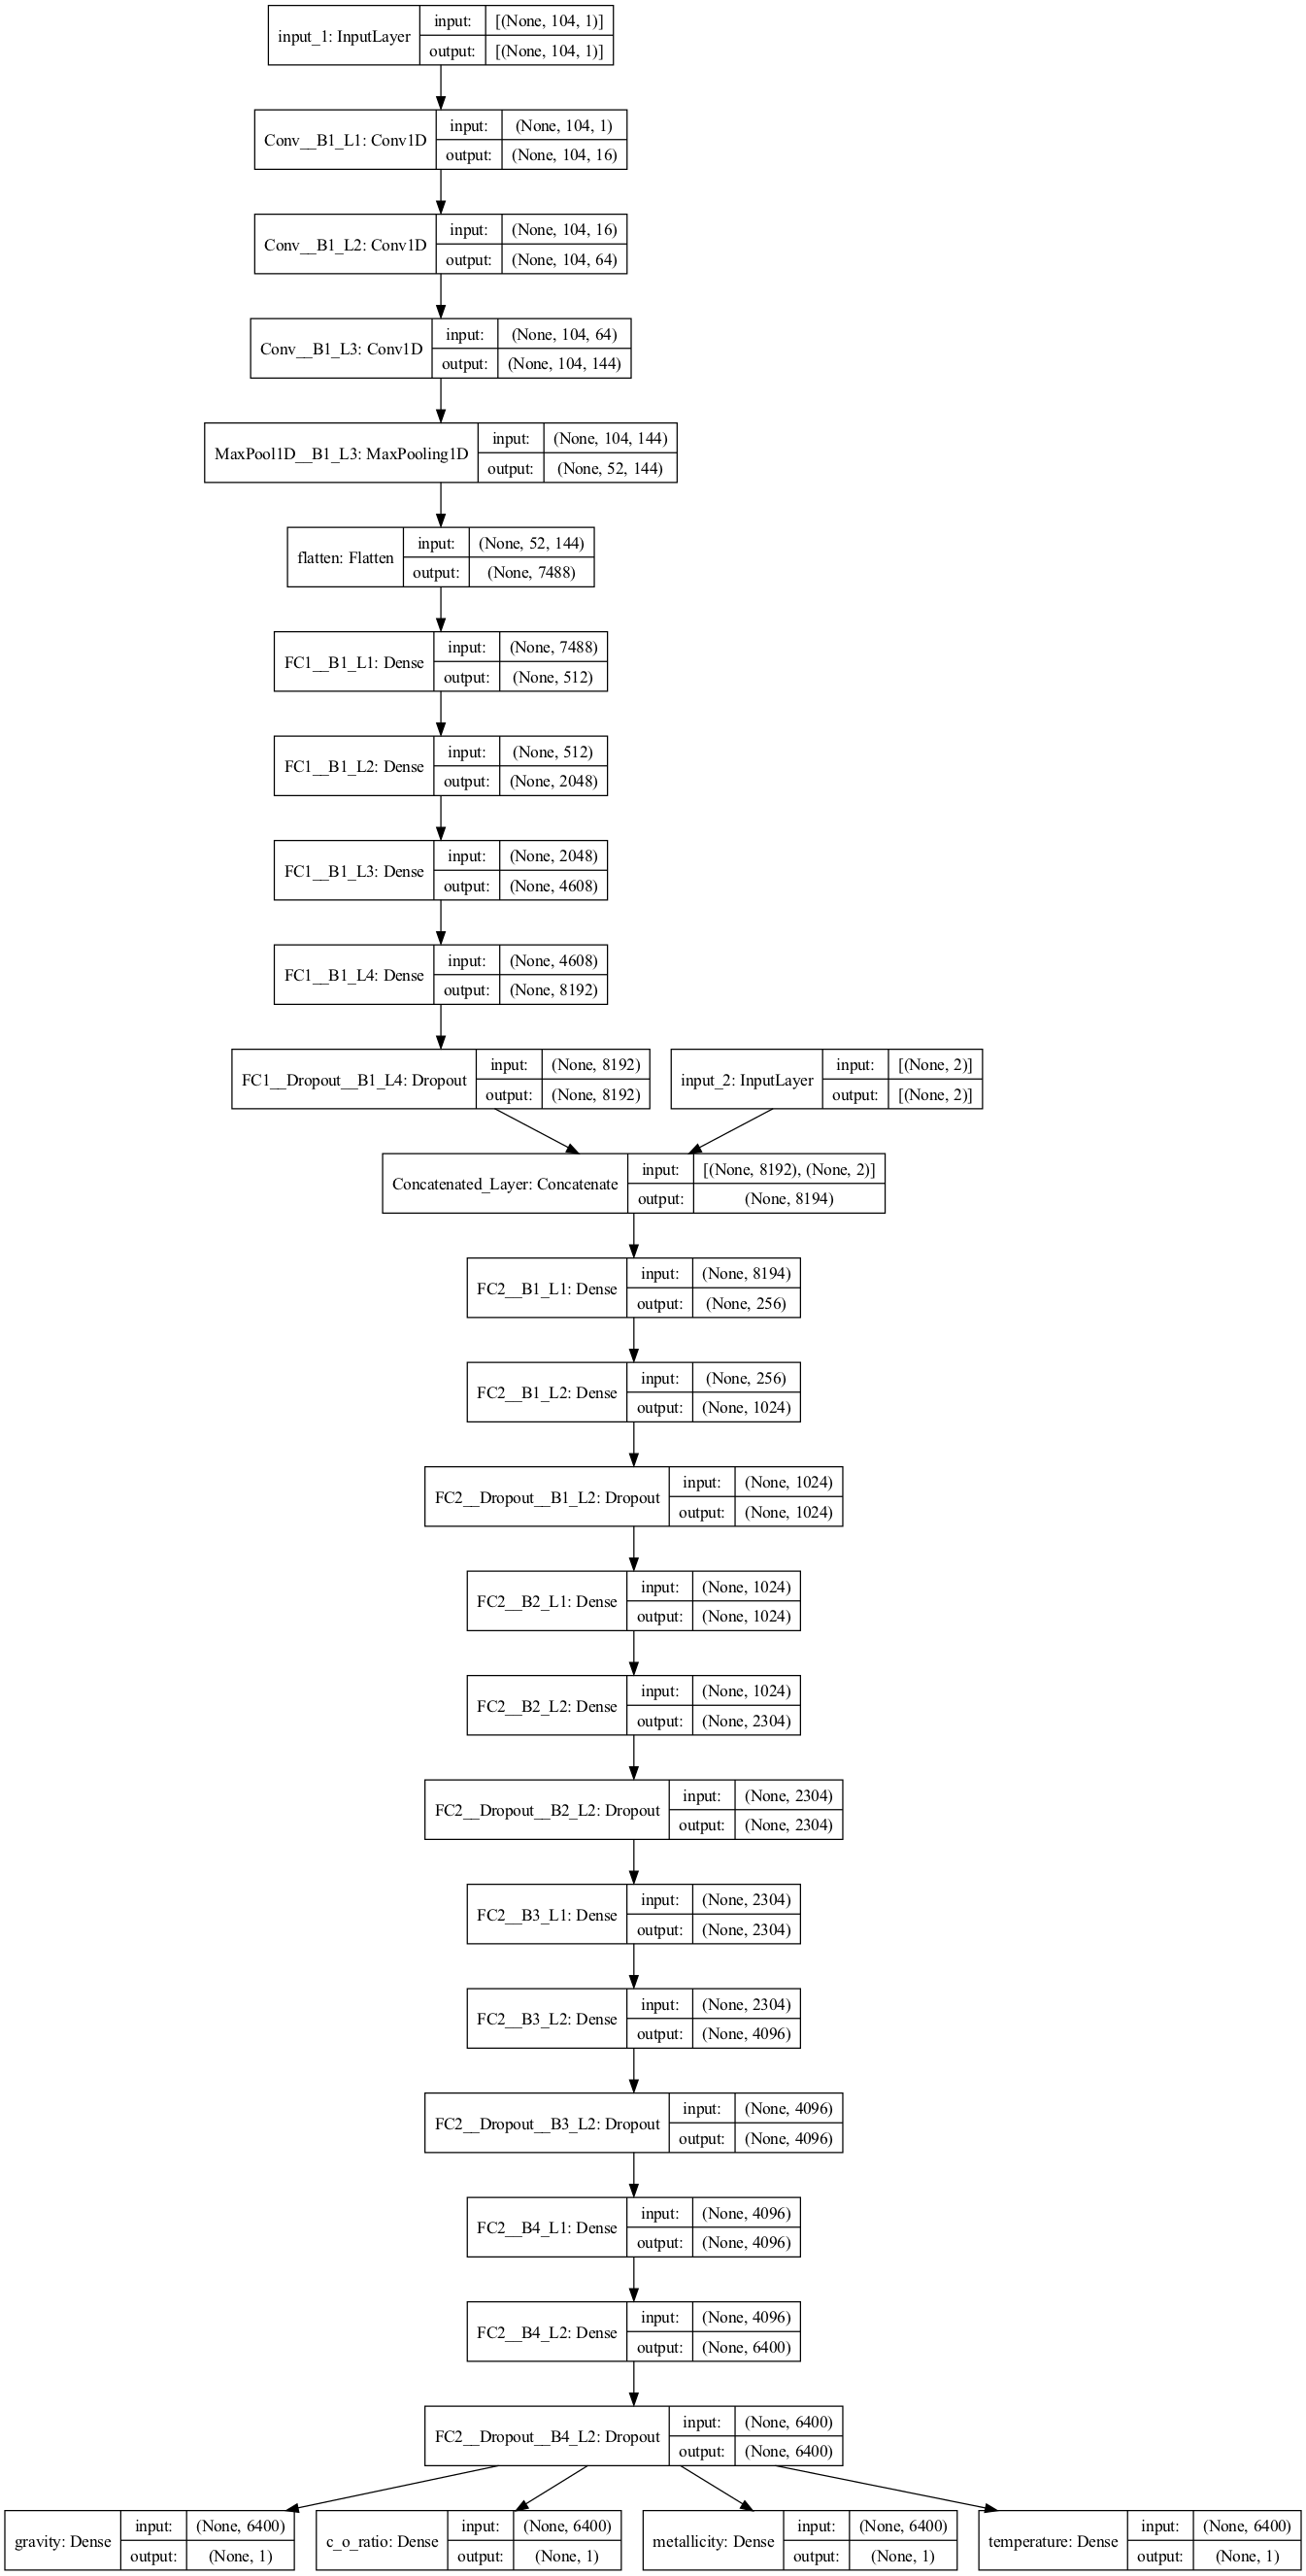

In [29]:
tf.keras.utils.plot_model(
                train_cnn_model.model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

### 3.3.6 Trained Model Outcomes

In [30]:
load_or_dump_trained_model_CNN( trained_model = build_cnn_regression,
                                                        indicator='Toy_parameters_v4_1000epoch_v2_test',
                                                        load_or_dump = 'dump')

## 3.4 Check the performance of the Trained Model

### 3.4.1 Load the Saved Trained CNN Models

In [31]:
loaded_model, history = load_or_dump_trained_model_CNN(indicator='Toy_parameters_v4_1000epoch_v2_test',
                                                      load_or_dump = 'load')

In [32]:
build_cnn_regression.trained_model = model#loaded_model
build_cnn_regression.trained_model_history = history

### 3.4.2 Double-check the Trained CNN Archeticture and Summary

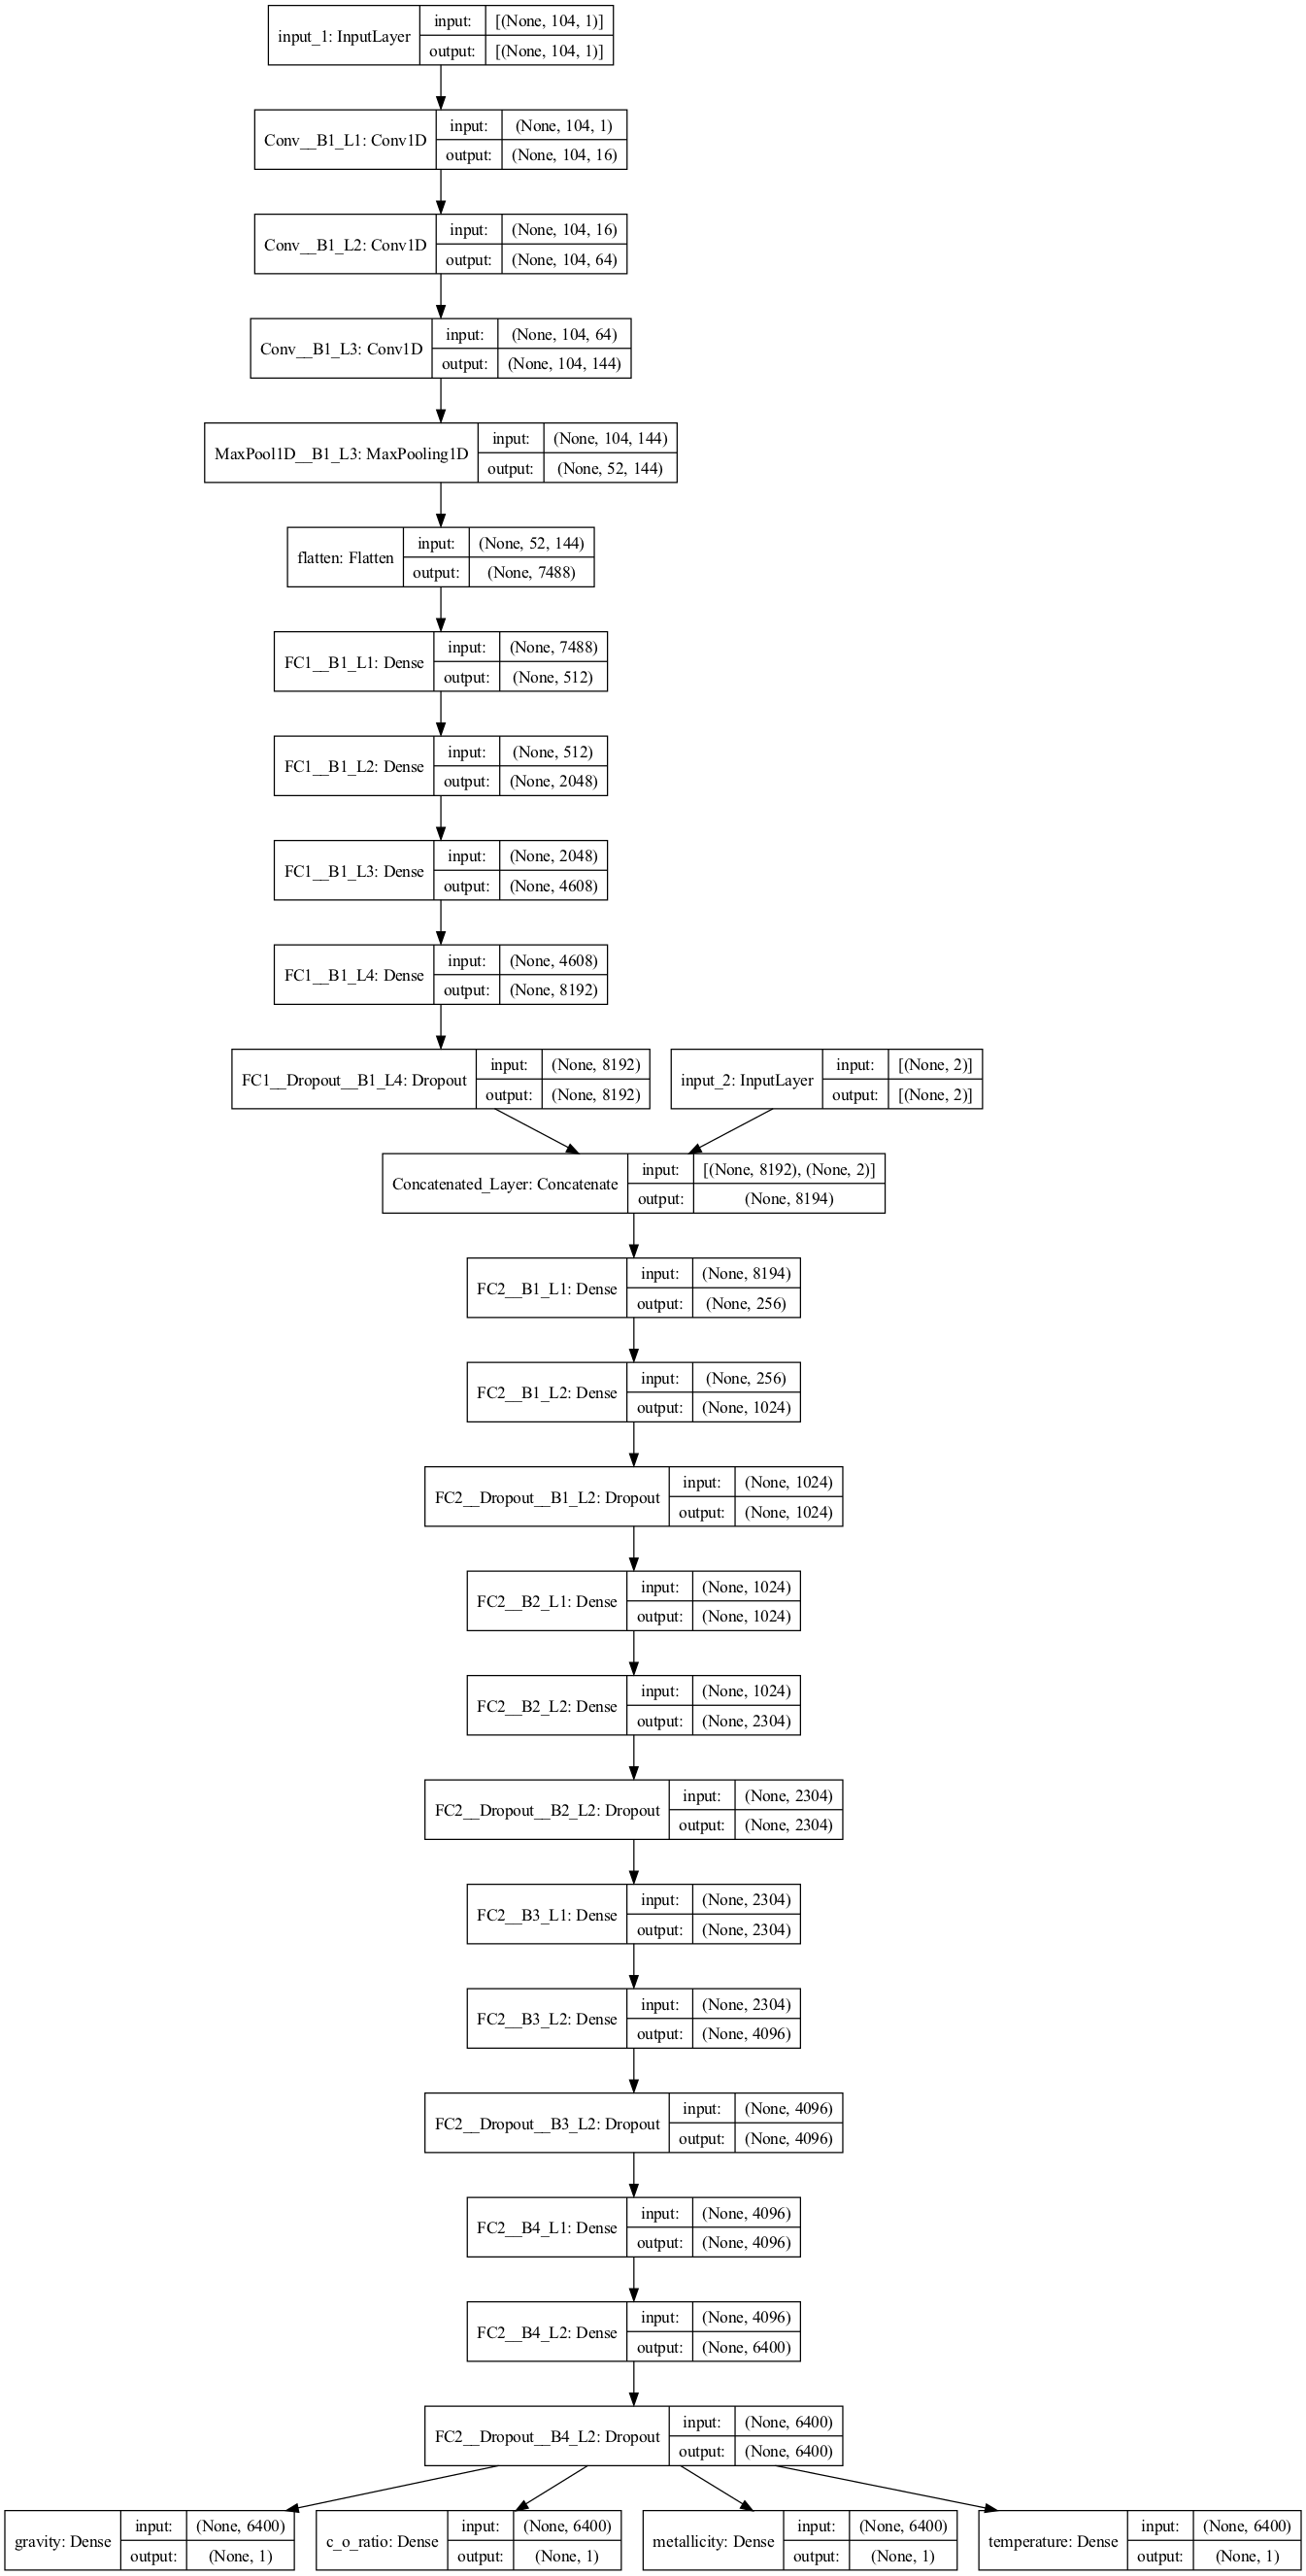

In [33]:
tf.keras.utils.plot_model(
                build_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

In [34]:
build_cnn_regression.trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 104, 1)]     0                                            
__________________________________________________________________________________________________
Conv__B1_L1 (Conv1D)            (None, 104, 16)      112         input_1[0][0]                    
__________________________________________________________________________________________________
Conv__B1_L2 (Conv1D)            (None, 104, 64)      6208        Conv__B1_L1[0][0]                
__________________________________________________________________________________________________
Conv__B1_L3 (Conv1D)            (None, 104, 144)     55440       Conv__B1_L2[0][0]                
______________________________________________________________________________________________

### 3.4.3  Check the training history through *Loss* metric

In [35]:
build_cnn_regression.plot_model_loss(title = 'RandState=100: X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### 3.4.4 Plot the Performance of the trained CNN models - Regression metrics
- Plot predicted against actual scatter plots for all parameters 
- Plot Residual histograms (predicted - Actual)
- Report regression metrics: R$^2$ and skewness for training and test sets

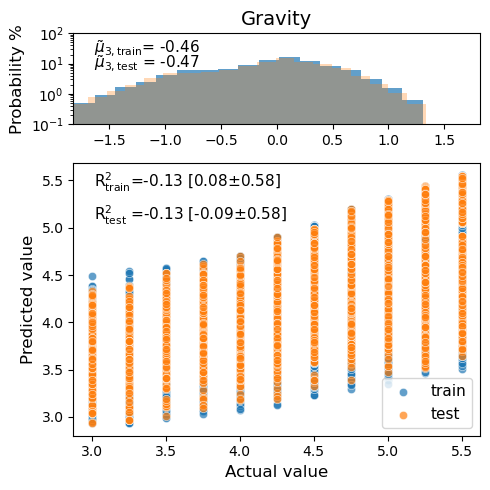

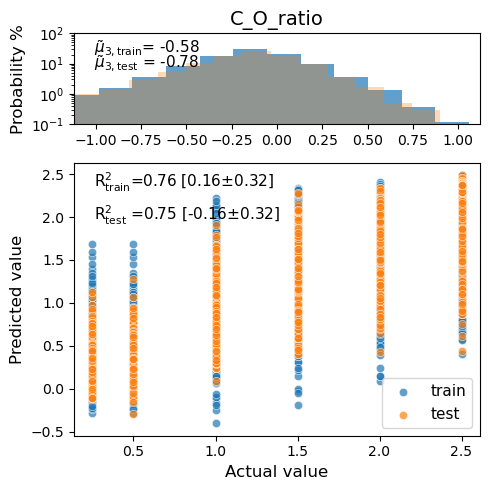

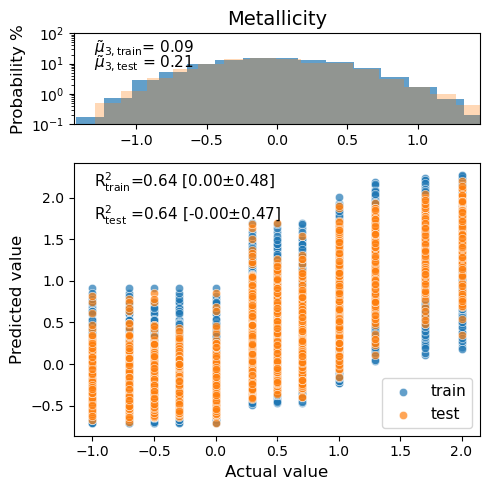

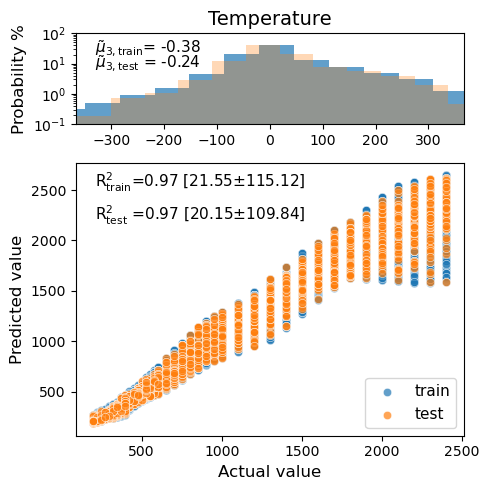

In [36]:
i = 1
regression_report(
        trained_model = build_cnn_regression,
    
        Xtrain = [build_cnn_regression.X_train_standardized_rowwise[::i],
                  build_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [build_cnn_regression.X_test_standardized_rowwise[::i], 
                  build_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = build_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = build_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
#         print_results = False,        
                 )